# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Wrangling
##  Data Assessing Summary
> - portfolio: 'channels' get dummies, encode 'id'
> - profile: 
>    - [ignore for now] Abnormal 'age' (118): 'gender' and 'income' are both empty
>    - 'became_member_on' wrong data type
> - transcript: 
>    - 'event' get dummies
>    - two variables in the 'value' column and they should be split

## Data Cleaning Summary
> - transcript: 

### Data Assessing: portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### Data Cleaning: portfolio

In [5]:
portfolio_cleaned = portfolio.copy()

In [6]:
channels_list = ['web', 'email', 'mobile', 'social']
for channel in channels_list:
    for ind, lst in enumerate(zip(portfolio_cleaned['channels'])):
        if channel in list(lst)[0]:
            portfolio_cleaned.loc[ind, channel] = 1
        else:
            portfolio_cleaned.loc[ind, channel] = 0
    portfolio_cleaned[channel] = portfolio_cleaned[channel].astype(int)

In [7]:
portfolio_cleaned = portfolio_cleaned.drop(['channels'], axis = 1)

In [8]:
def offer_mapper():
    coded_dict = dict()
    cter = 1
    offer_encoded = []
    
    for val in portfolio_cleaned['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        offer_encoded.append(coded_dict[val])
    return offer_encoded

offer_encoded = offer_mapper()
portfolio_cleaned['offer_encoded'] = offer_encoded

In [9]:
portfolio_cleaned

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_encoded
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,2
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,4
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,5
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,6
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,7
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,8
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,9
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,10


### Data Assessing: profile

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


### Data Cleaning: profile

In [13]:
profile_cleaned = profile.copy()

In [14]:
profile_cleaned['age_group'] = pd.cut(profile_cleaned['age'], bins=[0, 19, 39, 59, 79, 99, 119])
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')

In [15]:
today_date = date.today()
profile_cleaned['membership_months'] = profile_cleaned['became_member_on'].apply(lambda x: (today_date.year - x.year) * 12 + (today_date.month - x.month))
profile_cleaned['membership_years'] = profile_cleaned['became_member_on'].apply(lambda x: ((today_date.year - x.year) * 12 + (today_date.month - x.month))/12)
profile_cleaned['membership_years_group'] = pd.cut(profile_cleaned['membership_years'], bins=[3, 4, 5, 6, 7, 8, 9])

In [16]:
profile_cleaned.describe()

,age,income,membership_months,membership_years
count,17000.000000,14825.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,56.696471,4.724706
std,26.738580,21598.299410,13.515831,1.126319
min,18.000000,30000.000000,40.000000,3.333333
25%,45.000000,49000.000000,47.000000,3.916667
50%,58.000000,64000.000000,51.000000,4.250000
75%,73.000000,80000.000000,66.000000,5.500000
max,118.000000,120000.000000,100.000000,8.333333


In [17]:
profile_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   gender                  14825 non-null  object        
 1   age                     17000 non-null  int64         
 2   id                      17000 non-null  object        
 3   became_member_on        17000 non-null  datetime64[ns]
 4   income                  14825 non-null  float64       
 5   age_group               17000 non-null  category      
 6   membership_months       17000 non-null  int64         
 7   membership_years        17000 non-null  float64       
 8   membership_years_group  17000 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 963.5+ KB


In [18]:
profile_cleaned.head()

,gender,age,id,became_member_on,income,age_group,membership_months,membership_years,membership_years_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,"(99, 119]",57,4.750000,"(4, 5]"
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,"(39, 59]",52,4.333333,"(4, 5]"
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,"(99, 119]",40,3.333333,"(3, 4]"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,"(59, 79]",54,4.500000,"(4, 5]"
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,"(99, 119]",51,4.250000,"(4, 5]"


### Data Assessing: transcript

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Data Cleaning: transcript

In [21]:
transcript_cleaned = transcript.copy()

In [22]:
tmp_df = transcript_cleaned['value'].apply(pd.Series)
transcript_cleaned = pd.concat([transcript_cleaned, tmp_df], axis=1)

In [23]:
transcript_cleaned['offer id'].fillna('', inplace = True)
transcript_cleaned['offer_id'].fillna('', inplace = True)

In [24]:
transcript_cleaned['offer id'] = transcript_cleaned['offer id'] + transcript_cleaned['offer_id']
transcript_cleaned.drop('offer_id', axis=1, inplace=True)

In [25]:
transcript_cleaned.head()

,person,event,value,time,offer id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Merge three dataframes into one master dataframe

In [26]:
transcript_profile = pd.merge(transcript_cleaned, profile_cleaned, how='left', left_on = 'person', right_on = 'id')
df_master = pd.merge(transcript_profile, portfolio_cleaned, how='left', left_on = 'offer id', right_on = 'id')

In [27]:
def person_mapper():
    coded_dict = dict()
    cter = 1
    person_encoded = []
    
    for val in df_master['person']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        person_encoded.append(coded_dict[val])
    return person_encoded

person_encoded = person_mapper()
del df_master['person']
df_master['person_encoded'] = person_encoded
df_master.insert(0, 'person_encoded', df_master.pop('person_encoded'))

In [28]:
df_master.rename(columns = {'reward_y': 'reward'}, inplace = True)
df_master = df_master.drop(['offer id', 'id_x', 'value', 'id_y', 'reward_x', 'became_member_on'], axis=1)

In [29]:
df_master.head()

,person_encoded,event,time,amount,gender,age,income,age_group,membership_months,membership_years,membership_years_group,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_encoded
0,1,offer received,0,NaN,F,75,100000.0,"(59, 79]",54,4.500000,"(4, 5]",5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,4.0
1,2,offer received,0,NaN,None,118,NaN,"(99, 119]",51,4.250000,"(4, 5]",5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,5.0
2,3,offer received,0,NaN,M,68,70000.0,"(59, 79]",43,3.583333,"(3, 4]",2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,10.0
3,4,offer received,0,NaN,None,118,NaN,"(99, 119]",50,4.166667,"(4, 5]",2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,7.0
4,5,offer received,0,NaN,None,118,NaN,"(99, 119]",49,4.083333,"(4, 5]",10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,2.0


In [30]:
df_master.to_csv('starbucks_master.csv', index = False)

# Exploratory Data Analysis

In [31]:
starbucks_df = pd.read_csv('starbucks_master.csv')

In [32]:
starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   person_encoded          306534 non-null  int64  
 1   event                   306534 non-null  object 
 2   time                    306534 non-null  int64  
 3   amount                  138953 non-null  float64
 4   gender                  272762 non-null  object 
 5   age                     306534 non-null  int64  
 6   income                  272762 non-null  float64
 7   age_group               306534 non-null  object 
 8   membership_months       306534 non-null  int64  
 9   membership_years        306534 non-null  float64
 10  membership_years_group  306534 non-null  object 
 11  reward                  167581 non-null  float64
 12  difficulty              167581 non-null  float64
 13  duration                167581 non-null  float64
 14  offer_type          

In [33]:
starbucks_df['age_group'] = starbucks_df['age_group'].map({'(0, 19]': '0-19',
                            '(19, 39]': '20-39',
                            '(39, 59]': '40-59',
                            '(59, 79]': '60-79',
                            '(79, 99]': '80-99',
                            '(99, 119]': '100-119'
                            })
age_groups = pd.api.types.CategoricalDtype(ordered = True, categories = ['0-19', '20-39', '40-59', '60-79', '80-99', '100-119'])
starbucks_df['age_group'] = starbucks_df['age_group'].astype(age_groups)

starbucks_df['membership_years_group'] = starbucks_df['membership_years_group'].map({'(3, 4]': '(3-4]',
                            '(4, 5]': '(4-5]',
                            '(5, 6]': '(5-6]',
                            '(6, 7]': '(6-7]',
                            '(7, 8]': '(7-8]',
                            '(8, 9]': '(8-9]'
                            })
member_groups = pd.api.types.CategoricalDtype(ordered = True, categories = ['(3-4]', '(4-5]', '(5-6]', '(6-7]', '(7-8]', '(8-9]'])
starbucks_df['membership_years_group'] = starbucks_df['membership_years_group'].astype(member_groups)


## Offer Analysis

In [34]:
exploratory_df = starbucks_df[starbucks_df['event']=='offer received']

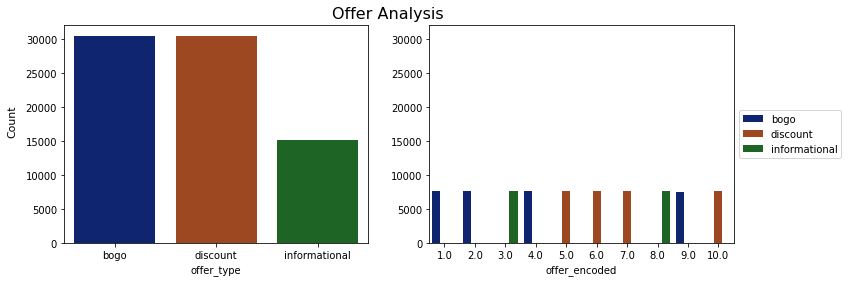

In [35]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1, 2, 1)
sns.countplot(data = exploratory_df, x = 'offer_type', palette = 'dark')
ax1.set_ylabel('')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
sns.countplot(data = exploratory_df, x = 'offer_encoded', hue = 'offer_type', palette = 'dark')
ax2.set_ylabel('')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('Offer Analysis', ha='center', va='center', fontsize=16, y=0.92)
fig.text(0.065, 0.55,'Count', ha='center', va='center', rotation='vertical', fontsize=11)
plt.show()

## Customer Analysis

In [36]:
starbucks_df.isnull().sum()

person_encoded                 0
event                          0
time                           0
amount                    167581
gender                     33772
age                            0
income                     33772
age_group                      0
membership_months              0
membership_years               0
membership_years_group         0
reward                    138953
difficulty                138953
duration                  138953
offer_type                138953
web                       138953
email                     138953
mobile                    138953
social                    138953
offer_encoded             138953
dtype: int64

In [37]:
len(starbucks_df[starbucks_df['age']==118])

33772

In [38]:
# Remove customers with age = 118
starbucks_df = starbucks_df[starbucks_df['age']!=118]

# Remove customers with gender = 'O'
starbucks_df = starbucks_df[starbucks_df['gender']!='O']

In [39]:
starbucks_df = starbucks_df.reset_index(drop = True)

In [40]:
starbucks_df['income_group'] = pd.cut(starbucks_df['income'], bins=[20000, 40000, 60000, 80000, 100000, 120000])
starbucks_df['income_group'] = starbucks_df['income_group'].astype(str)
starbucks_df['income_group'] = starbucks_df['income_group'].map({'(20000, 40000]': '20k-40k',
                                                                 '(40000, 60000]': '40k-60k',
                                                                 '(60000, 80000]': '60k-80k',
                                                                 '(80000, 100000]': '80k-100k',
                                                                 '(100000, 120000]': '100k-120k'
                                                                })
income_groups = pd.api.types.CategoricalDtype(ordered = True, categories = ['20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k'])
starbucks_df['income_group'] = starbucks_df['income_group'].astype(income_groups)

In [41]:
starbucks_df.head()

,person_encoded,event,time,amount,gender,age,income,age_group,membership_months,membership_years,...,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_encoded,income_group
0,1,offer received,0,NaN,F,75,100000.0,60-79,54,4.500000,...,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,4.0,80k-100k
1,3,offer received,0,NaN,M,68,70000.0,60-79,43,3.583333,...,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,10.0,60k-80k
2,6,offer received,0,NaN,M,65,53000.0,60-79,45,3.750000,...,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,9.0,40k-60k
3,8,offer received,0,NaN,M,58,51000.0,40-59,48,4.000000,...,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,40k-60k
4,9,offer received,0,NaN,F,61,57000.0,60-79,50,4.166667,...,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,5.0,40k-60k


In [42]:
starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268791 entries, 0 to 268790
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   person_encoded          268791 non-null  int64   
 1   event                   268791 non-null  object  
 2   time                    268791 non-null  int64   
 3   amount                  122176 non-null  float64 
 4   gender                  268791 non-null  object  
 5   age                     268791 non-null  int64   
 6   income                  268791 non-null  float64 
 7   age_group               268791 non-null  category
 8   membership_months       268791 non-null  int64   
 9   membership_years        268791 non-null  float64 
 10  membership_years_group  268791 non-null  category
 11  reward                  146615 non-null  float64 
 12  difficulty              146615 non-null  float64 
 13  duration                146615 non-null  float64 
 14  offe

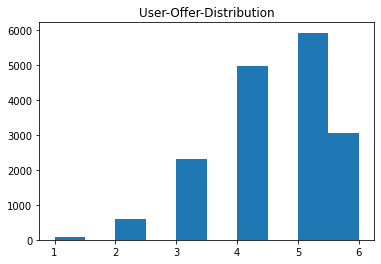

In [43]:
user_offer_received_series = exploratory_df.groupby('person_encoded')['event'].count()
plt.hist(user_offer_received_series)
plt.title('User-Offer-Distribution')
plt.show()

### Categorical Variables Exploration

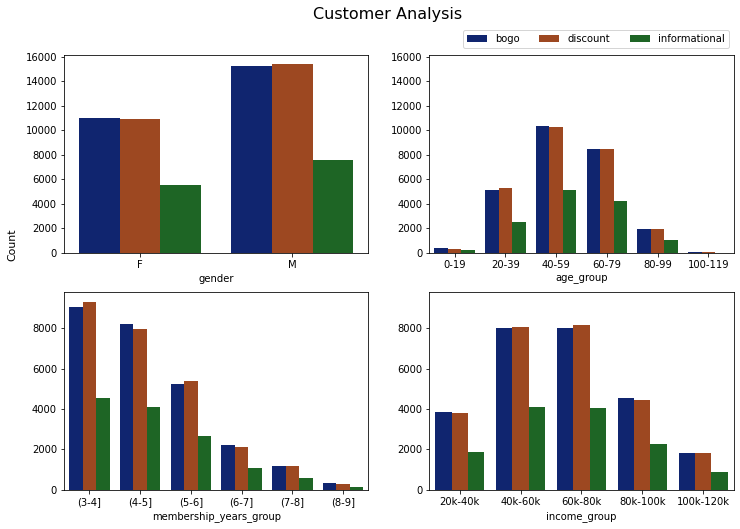

In [44]:
fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data = starbucks_df[starbucks_df['event']=='offer received'], x = 'gender', hue = 'offer_type', palette = 'dark')
ax1.set_ylabel('')
ax1.legend(ncol=3, loc = 'center left', bbox_to_anchor=([-0.015, 1.08, 0, 0]))
ax1.legend([],[], frameon=False)

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
sns.countplot(data = starbucks_df[starbucks_df['event']=='offer received'], x = 'age_group', hue = 'offer_type', palette = 'dark')
ax2.set_ylabel('')
ax2.legend(ncol=3, loc = 'center right', bbox_to_anchor=([1, 1.08, 0, 0]))

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data = starbucks_df[starbucks_df['event']=='offer received'], x = 'membership_years_group', hue = 'offer_type', palette = 'dark')
ax3.set_ylabel('')
ax3.legend([],[], frameon=False)

ax4 = plt.subplot(2, 2, 4, sharey=ax3)
sns.countplot(data = starbucks_df[starbucks_df['event']=='offer received'], x = 'income_group', hue = 'offer_type', palette = 'dark')
ax4.set_ylabel('')
ax4.legend([],[], frameon=False)

fig.suptitle('Customer Analysis', ha='center', va='center', fontsize=16, y=0.95)
fig.text(0.065, 0.55,'Count', ha='center', va='center', rotation='vertical', fontsize=11)
plt.show()

In [45]:
starbucks_df.groupby('person_encoded')['income'].mean().sort_values(ascending=False).median()

64000.0

In [47]:
print('Total duration of the test in days: {}'.format(starbucks_df.time.max()/24))

Total duration of the test in days: 29.75


# Data Preparation

### Converted offers: 
> - BOGO/Discount: Demographic group that made purchasing decisions which influenced by promotional offers ('offer received' -> 'offer viewed' -> 'transaction' -> 'offer completed')
> - Informational: Demographic group that made purchases within the validity period after viewing the advertisement ('offer received' -> 'offer viewed' -> 'transaction')

### Unconverted offers:
> - BOGO/Discount: Demographic group that viewed the offer but did not make any purchases or failed to complete the offer. ('offer received' -> 'offer viewed')
> - Informational: Demographic group that did not make any purchases within the validity period after receiving the advertisement ('offer received' -> 'offer viewed')

### Unnecessary offers:
> - BOGO/Discount: Demographic group that made purchases  before viewing or without viewing any offers. ('offer received' -> 'transaction' -> 'offer completed' -> 'offer viewed')
> - Informational: Demographic group that made purchases within the validity period before viewing the offer ('offer received' -> 'transaction' -> 'offer viewed')

## BOGO and Discount

In [48]:
bogo_discount_df = starbucks_df[(starbucks_df['offer_type'] =='bogo') | (starbucks_df['offer_type'] =='discount') | (starbucks_df['event'] =='transaction')]

### [BOGO/Discount] Group 1: Converted Offer ('offer received' -> 'offer viewed' -> 'transaction' -> 'offer completed')
### Effective Converted Bogo/Discount

In [49]:
starbucks_df.head()

,person_encoded,event,time,amount,gender,age,income,age_group,membership_months,membership_years,...,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_encoded,income_group
0,1,offer received,0,NaN,F,75,100000.0,60-79,54,4.500000,...,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,4.0,80k-100k
1,3,offer received,0,NaN,M,68,70000.0,60-79,43,3.583333,...,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,10.0,60k-80k
2,6,offer received,0,NaN,M,65,53000.0,60-79,45,3.750000,...,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,9.0,40k-60k
3,8,offer received,0,NaN,M,58,51000.0,40-59,48,4.000000,...,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,40k-60k
4,9,offer received,0,NaN,F,61,57000.0,60-79,50,4.166667,...,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,5.0,40k-60k


In [50]:
bogo_discount_df.head()

,person_encoded,event,time,amount,gender,age,income,age_group,membership_months,membership_years,...,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_encoded,income_group
0,1,offer received,0,NaN,F,75,100000.0,60-79,54,4.500000,...,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,4.0,80k-100k
1,3,offer received,0,NaN,M,68,70000.0,60-79,43,3.583333,...,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,10.0,60k-80k
2,6,offer received,0,NaN,M,65,53000.0,60-79,45,3.750000,...,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,9.0,40k-60k
4,9,offer received,0,NaN,F,61,57000.0,60-79,50,4.166667,...,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,5.0,40k-60k
5,10,offer received,0,NaN,F,62,71000.0,60-79,69,5.750000,...,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,5.0,60k-80k


In [51]:
def get_converted_bogo_discount(df):
    index_ls = []
    for user in df['person_encoded'].unique():
        tmp_df1 = df[df['person_encoded']==user]
        out_received_time_idx = []
        out_viewed_time_idx = []
        offer_idx_ls = []
        transaction_ls = []
        for index, row in tmp_df1.iterrows():
            if row['event'] == 'offer completed':
                completed_time = tmp_df1.loc[index, 'time']
                offer_id = tmp_df1.loc[index, 'offer_encoded']
                viewed_time_idx = list(tmp_df1[(tmp_df1['event'] == 'offer viewed') & (tmp_df1['offer_encoded'] == offer_id)].index)
                for idx in viewed_time_idx:
                    if (idx not in out_viewed_time_idx) and (idx < index) : # equivalent to viewed_time < completed_time:
                        viewed_time = tmp_df1.loc[idx, 'time']
                        for transaction_time in list(tmp_df1[tmp_df1['event'] == 'transaction']['time']):
                            if (transaction_time >= viewed_time) and (transaction_time <= completed_time): # get all transactions between offer viewed and completed
                                transaction_ls.append(tmp_df1[(tmp_df1['event'] == 'transaction') & (tmp_df1['time'] == transaction_time)].index[0])
                                offer_idx_ls.append(index) # completed_time index
                                offer_idx_ls.append(idx) # viewed_time index
                                out_viewed_time_idx.append(idx)
                                received_time_idx = list(tmp_df1[(tmp_df1['event'] == 'offer received') & (tmp_df1['offer_encoded'] == offer_id)].index)
                                for received_idx in received_time_idx:
                                    if (received_idx not in out_received_time_idx) and (received_idx < idx):
                                        offer_idx_ls.append(received_idx) # received_time index    
                                        out_received_time_idx.append(received_idx)     
        index_ls = index_ls + offer_idx_ls + transaction_ls 
    return sorted(list(set(index_ls)))

In [52]:
starbucks_df.loc[:,'converted'] = np.nan

In [53]:
starbucks_df.loc[get_converted_bogo_discount(bogo_discount_df), 'converted'] = 1.0

### [BOGO/Discount] Group 2: Demographic group that viewed the offer but did not make any purchases. ('offer received' -> 'offer viewed')
### Unconverted Bogo/Discount

In [54]:
def get_unconverted_bogo_discount(df):
    index_ls = []
    for user in df['person_encoded'].unique():
        tmp_df1 = df[(df['person_encoded']==user) & ((df['offer_type'] =='bogo') | (df['offer_type'] =='discount'))]
        index_ls = index_ls + list(tmp_df1[~tmp_df1['offer_encoded'].isin(tmp_df1[tmp_df1['event'] == 'offer completed']['offer_encoded'])].index)
    return sorted(list(set(index_ls)))

In [55]:
starbucks_df.loc[get_unconverted_bogo_discount(bogo_discount_df), 'converted'] = 0.0

### [BOGO/Discount] Group 3: Demographic group that made purchases without receiving or viewing any offers. ('offer received' -> 'transaction' -> 'offer completed')

In [56]:
# Group 2.1 : only purchase without receiving any offers
all_unique_users = starbucks_df['person_encoded'].unique()
users_received_offer = starbucks_df[starbucks_df['event']=='offer received']['person_encoded'].unique()
users_without_offer = np.setdiff1d(all_unique_users, users_received_offer)
users_without_offer_df = starbucks_df[starbucks_df['person_encoded'].isin(users_without_offer)]

In [57]:
# only 6 persons did not receive any offer but still made purchases
users_without_offer_df['person_encoded'].unique()

array([12803, 13089, 16519, 16728, 16743])

### Ineffective Converted Bogo/Discount

In [58]:
def get_unnecessary_bogo_discount(df):
    index_ls = []
    for user in df['person_encoded'].unique():
        tmp_df1 = df[df['person_encoded'] == user]
        offer_idx_ls = []
        transaction_ls = []
        tmp_df1 = bogo_discount_df[bogo_discount_df['person_encoded']==user]
        out_received_time_idx = []
        out_viewed_time_idx = []
        for index, row in tmp_df1.iterrows():
            if row['event'] == 'offer completed':
                completed_time = tmp_df1.loc[index, 'time']
                offer_id = tmp_df1.loc[index, 'offer_encoded']
                if offer_id not in list(tmp_df1[(tmp_df1['event'] == 'offer viewed') & (tmp_df1['offer_encoded'] == offer_id)]['offer_encoded']):
                    received_time_idx = list(tmp_df1[(tmp_df1['event'] == 'offer received') & (tmp_df1['offer_encoded'] == offer_id)].index)
                    for received_idx in received_time_idx:
                        if (received_idx not in out_received_time_idx) and (received_idx < index):
                            received_time = tmp_df1.loc[received_idx, 'time']
                            for transaction_time in list(tmp_df1[tmp_df1['event'] == 'transaction']['time']):
                                if (transaction_time >= received_time) and (transaction_time <= completed_time): # get all transactions between offer recevied and completed
                                    transaction_ls.append(tmp_df1[(tmp_df1['event'] == 'transaction') & (tmp_df1['time'] == transaction_time)].index[0])
                                    offer_idx_ls.append(index) # completed_time index
                                    offer_idx_ls.append(received_idx) # received_time index
                                    out_received_time_idx.append(received_idx)
                else:
                    viewed_time_idx = list(tmp_df1[(tmp_df1['event'] == 'offer viewed') & (tmp_df1['offer_encoded'] == offer_id)].index)
                    for idx in viewed_time_idx:
                        if (idx not in out_viewed_time_idx) and (idx < index):
                            out_viewed_time_idx.append(idx)
                            received_time_idx = list(tmp_df1[(tmp_df1['event'] == 'offer received') & (tmp_df1['offer_encoded'] == offer_id)].index)
                            for received_idx in received_time_idx:
                                if (received_idx not in out_received_time_idx) and (received_idx < idx):
                                    out_received_time_idx.append(received_idx)
                            break
                        if (idx not in out_viewed_time_idx) and (idx > index): # equivalent to viewed_time > completed_time: # 
                            viewed_time = tmp_df1.loc[idx, 'time']
                            for transaction_time in list(tmp_df1[tmp_df1['event'] == 'transaction']['time']):
                                if (transaction_time <= viewed_time) and (transaction_time >= completed_time): # get all transactions between offer completed and viewed
                                    transaction_ls.append(tmp_df1[(tmp_df1['event'] == 'transaction') & (tmp_df1['time'] == transaction_time)].index[0])
                                    offer_idx_ls.append(index) # completed_time index
                                    offer_idx_ls.append(idx) # viewed_time index
                                    out_viewed_time_idx.append(idx)
                                    received_time_idx = list(tmp_df1[(tmp_df1['event'] == 'offer received') & (tmp_df1['offer_encoded'] == offer_id)].index)
                                    for received_idx in received_time_idx:
                                        if (received_idx not in out_received_time_idx) and (received_idx < idx):
                                            offer_idx_ls.append(received_idx) # received_time index
                                            out_received_time_idx.append(received_idx)   
        index_ls = index_ls + offer_idx_ls + transaction_ls 
    return sorted(list(set(index_ls)))

In [59]:
starbucks_df.loc[get_unnecessary_bogo_discount(bogo_discount_df), 'converted'] = 0.5

## Informational

### Considering duration of offers for informational offers to mark them as converted/successful
> - for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

In [60]:
informational_df = starbucks_df[(starbucks_df['offer_type'] =='informational') | (starbucks_df['event'] =='transaction')]

In [61]:
def get_full_process_informational(df):
    index_ls = []
    for user in df['person_encoded'].unique():
        offer_idx_ls = []
        # transaction_ls = []
        valid_transaction_idx = []
        tmp_df1 = df[df['person_encoded'] == user]
        for offer_id in list(tmp_df1[tmp_df1['event'] == 'offer viewed']['offer_encoded']): # only get the informational offer that were viewed
            tmp_df2 = tmp_df1[(tmp_df1['person_encoded'] == user) & (tmp_df1['offer_encoded'] == offer_id)][['event','time','offer_encoded']] # dataframe including received and viewed
            offer_time = tmp_df2[tmp_df2['event'] == 'offer received']['time']
            for t in range(len(offer_time)):
                transaction_ls = []
                for transaction_time in list(tmp_df1[tmp_df1['event'] == 'transaction']['time']):
                    if transaction_time >= offer_time.iloc[t]: # transaction after receiving the informational offer
                        transaction_ls.append(tmp_df1[(tmp_df1['event'] == 'transaction') & (tmp_df1['time'] == transaction_time)].index[0])
                        offer_idx_ls = offer_idx_ls + list(tmp_df1[tmp_df1['offer_encoded'] == offer_id].index)   
                try:
                    valid_transaction_idx.append(min(transaction_ls)) # only the first transaction after received or viewed
                except ValueError:
                    pass
        index_ls = index_ls + offer_idx_ls + valid_transaction_idx
    return sorted(list(set(index_ls)))

# Converted informational offer
def get_converted_informational(df):
    index_ls = []
    for user in df['person_encoded'].unique():
        tmp_df1 = df[df['person_encoded'] == user]
        offer_idx_ls = []
        transaction_ls = []
        for offer_id in list(tmp_df1[tmp_df1['event'] == 'offer viewed']['offer_encoded']):
            tmp_df2 = tmp_df1[(tmp_df1['person_encoded'] == user) & (tmp_df1['offer_encoded'] == offer_id)][['event','time','offer_encoded', 'duration']]
            offer_received_time = tmp_df2[tmp_df2['event'] == 'offer received']['time']
            offer_viewed_time = tmp_df2[tmp_df2['event'] == 'offer viewed']['time']
            offer_duration = tmp_df2[tmp_df2['event'] == 'offer received']['duration'].unique()[0]*24
            for t in range(len(offer_viewed_time)):
                for transaction_time in list(tmp_df1[tmp_df1['event'] == 'transaction']['time']):
                    if (transaction_time >= offer_viewed_time.iloc[t]) and ((transaction_time - offer_received_time.iloc[t]) >= 0) and ((transaction_time - offer_received_time.iloc[t]) <= offer_duration):
                        transaction_ls.append(tmp_df1[(tmp_df1['event'] == 'transaction') & (tmp_df1['time'] == transaction_time)].index[0])
                        offer_idx_ls = offer_idx_ls + list(tmp_df2.index)
        index_ls = index_ls + offer_idx_ls + transaction_ls
    return sorted(list(set(index_ls)))

def get_unnecessary_informational(df):
    index_ls = []
    for user in df['person_encoded'].unique():
        tmp_df1 = df[df['person_encoded'] == user]
        offer_idx_ls = []
        transaction_ls = []
        for offer_id in list(tmp_df1[tmp_df1['event'] == 'offer viewed']['offer_encoded']):
            tmp_df2 = tmp_df1[(tmp_df1['person_encoded'] == user) & (tmp_df1['offer_encoded'] == offer_id)][['event','time','offer_encoded', 'duration']]
            offer_received_time = tmp_df2[tmp_df2['event'] == 'offer received']['time']
            offer_viewed_time = tmp_df2[tmp_df2['event'] == 'offer viewed']['time']
            offer_duration = tmp_df2[tmp_df2['event'] == 'offer received']['duration'].unique()[0]*24
            for t in range(len(offer_viewed_time)):
                for transaction_time in list(tmp_df1[tmp_df1['event'] == 'transaction']['time']):
                    if (transaction_time < offer_viewed_time.iloc[t]) and ((transaction_time - offer_received_time.iloc[t]) >= 0) and ((transaction_time - offer_received_time.iloc[t]) <= offer_duration):
                        transaction_ls.append(tmp_df1[(tmp_df1['event'] == 'transaction') & (tmp_df1['time'] == transaction_time)].index[0])
                        offer_idx_ls = offer_idx_ls + list(tmp_df2.index)
        index_ls = index_ls + offer_idx_ls + transaction_ls
    return sorted(list(set(index_ls)))

In [62]:
full_process_informational_df = starbucks_df.iloc[get_full_process_informational(informational_df)].copy()

In [63]:
converted_informational_df_index = get_converted_informational(full_process_informational_df)

In [64]:
starbucks_df.loc[get_converted_informational(full_process_informational_df), 'converted'] = 1.0

In [65]:
starbucks_df.loc[np.setdiff1d(full_process_informational_df.index, converted_informational_df_index), 'converted'] = 0.0

In [66]:
starbucks_df.loc[get_unnecessary_informational(full_process_informational_df), 'converted'] = 0.5

In [67]:
print('starbucks_df {}'.format(starbucks_df.shape[0]))
print('converted_starbucks_df {}'.format(len(starbucks_df[starbucks_df['converted']==1.0])))
print('unconverted_starbucks_df {}'.format(len(starbucks_df[starbucks_df['converted']==0.0])))
print('unnecessary_starbucks_df {}'.format(len(starbucks_df[starbucks_df['converted']==0.5])))

starbucks_df 268791
converted_starbucks_df 108132
unconverted_starbucks_df 37534
unnecessary_starbucks_df 43682


## Customer Demographical Analysis

In [68]:
total_received_df = starbucks_df[starbucks_df['event']=='offer received']

In [69]:
total_received_df.groupby(['offer_type']).agg({'person_encoded': 'count'})
# after removing the outliers of users with the age of 118

,person_encoded
offer_type,
bogo,26183
discount,26297
informational,13105


In [70]:
total_received_df.head()

,person_encoded,event,time,amount,gender,age,income,age_group,membership_months,membership_years,...,difficulty,duration,offer_type,web,email,mobile,social,offer_encoded,income_group,converted
0,1,offer received,0,NaN,F,75,100000.0,60-79,54,4.500000,...,5.0,7.0,bogo,1.0,1.0,1.0,0.0,4.0,80k-100k,1.0
1,3,offer received,0,NaN,M,68,70000.0,60-79,43,3.583333,...,10.0,7.0,discount,1.0,1.0,1.0,0.0,10.0,60k-80k,0.0
2,6,offer received,0,NaN,M,65,53000.0,60-79,45,3.750000,...,5.0,5.0,bogo,1.0,1.0,1.0,1.0,9.0,40k-60k,1.0
3,8,offer received,0,NaN,M,58,51000.0,40-59,48,4.000000,...,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,40k-60k,NaN
4,9,offer received,0,NaN,F,61,57000.0,60-79,50,4.166667,...,20.0,10.0,discount,1.0,1.0,0.0,0.0,5.0,40k-60k,0.0


## Conversion rate by offer types

In [71]:
def autolabel(bars):
  for bar in bars.patches:

    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done

    bars.annotate(str(np.round(bar.get_height(), 2)) + '%',
                  xy=(bar.get_x() + bar.get_width()/2,
                      bar.get_height()),
                  ha='center',
                  xytext=(0, 5),
                  textcoords='offset points', fontsize=10)

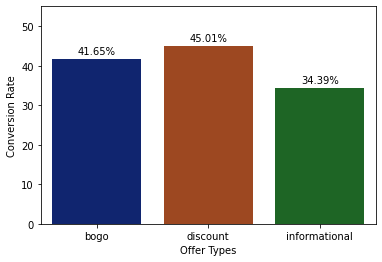

In [72]:
offer_total_df = total_received_df.groupby(['offer_type']).agg({'person_encoded':'count'})
offer_total_df.columns = ['total_count']
offer_total_df = offer_total_df.reset_index()

offer_converted_df = total_received_df[total_received_df['converted']==1.0].groupby(['offer_type']).agg({'person_encoded':'count'})
offer_converted_df.columns = ['converted_count']
offer_converted_df = offer_converted_df.reset_index()

converted_rt_df = offer_total_df.merge(offer_converted_df, how = 'inner', on = ['offer_type'])
converted_rt_df['converted_rt'] = converted_rt_df['converted_count'] / converted_rt_df['total_count'] * 100

fig = plt.figure(figsize=(6,4))
ax = sns.barplot(data = converted_rt_df, x = 'offer_type', y = 'converted_rt', palette = 'dark')
ax.set_ylabel('Conversion Rate')
ax.set_xlabel('Offer Types')
ax.set_ylim(0, 55)
# ax.set_title('Converted Offers')
autolabel(ax)
plt.show()

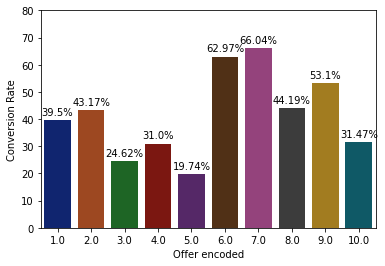

In [73]:
offer_total_df = total_received_df.groupby(['offer_encoded']).agg({'person_encoded':'count'})
offer_total_df.columns = ['total_count']
offer_total_df = offer_total_df.reset_index()

offer_converted_df = total_received_df[total_received_df['converted']==1.0].groupby(['offer_encoded']).agg({'person_encoded':'count'})
offer_converted_df.columns = ['converted_count']
offer_converted_df = offer_converted_df.reset_index()

converted_rt_df = offer_total_df.merge(offer_converted_df, how = 'inner', on = ['offer_encoded'])
converted_rt_df['converted_rt'] = converted_rt_df['converted_count'] / converted_rt_df['total_count'] * 100

fig = plt.figure(figsize=(6,4))
ax = sns.barplot(data = converted_rt_df, x = 'offer_encoded', y = 'converted_rt', palette = 'dark')
ax.set_ylabel('Conversion Rate')
ax.set_xlabel('Offer encoded')
ax.set_ylim(0, 80)
autolabel(ax)
plt.show()

## Conversion rate by offer types and demographic variables

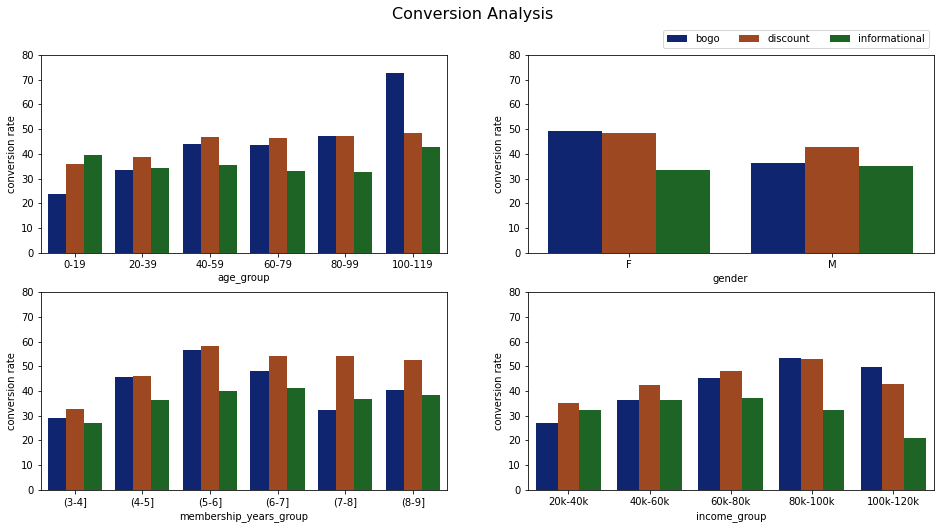

In [74]:
cat_ls = ['age_group', 'gender', 'membership_years_group', 'income_group']
fig = plt.figure(figsize = [16, 8])
for j in range(len(cat_ls)):

    df = total_received_df.groupby([cat_ls[j], 'offer_type']).agg({'person_encoded':'count'})
    df.columns = ['total_count']
    df = df.reset_index()

    converted_df = total_received_df[total_received_df['converted']==1.0].groupby([cat_ls[j], 'offer_type']).agg({'person_encoded':'count'})
    converted_df.columns = ['converted_count']
    converted_df = converted_df.reset_index()

    converted_rt_df = df.merge(converted_df, how = 'inner', on = [cat_ls[j], 'offer_type'])
    converted_rt_df['converted_rt'] = converted_rt_df['converted_count'] / converted_rt_df['total_count'] * 100

    ax = plt.subplot(2, 2, j+1)
    sns.barplot(data = converted_rt_df, x = cat_ls[j], y = 'converted_rt', hue = 'offer_type', palette = 'dark')
    ax.set_ylabel('conversion rate')
    ax.set_ylim(0, 80)
    if j!=1:
        ax.legend([],[], frameon=False)
    else:
        ax.legend(ncol=3, loc = 'center right', bbox_to_anchor=([1, 1.08, 0, 0]))

fig.suptitle('Conversion Analysis', ha='center', va='center', fontsize=16, y=0.95)
plt.show()

> - Based on the visualizations above, we can see that for both offer and discount offer, the higher the income of the customer, they are more likely to convert. The conversion rates are also higher for customers who are above 40 years old and female customers tend to response better to the offers. On the other hand, informational offers were more effective among teenagers.
> - The converted rate of the bogo offer in the age group 100–119 years old is relatively high compared to others. This is just due to the fact that there were only 24 bogo offers sent out to the users of this group. The data is too small and we cannot conclude that bogo offer works better for this group.
> - The statistic shows customers who have more than 5 years membership opt for discount offer with a conversion rate of above 50%. This is a an important finding as Starbucks should send out more discount offers to this group of customers as the responses would more likely to be positive.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator


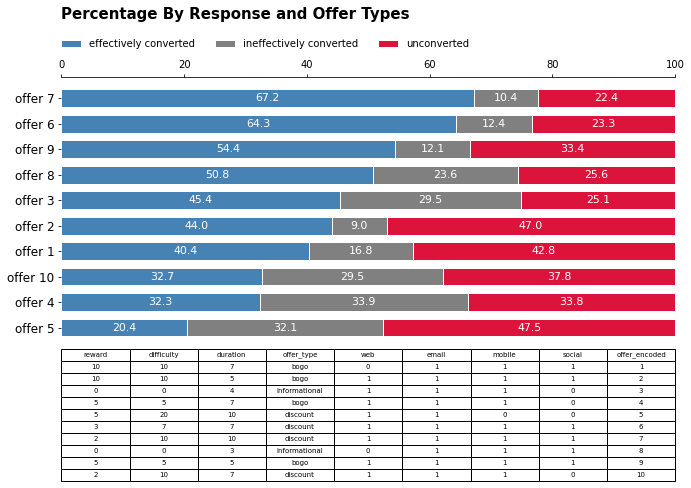

In [75]:
offer_df = total_received_df.groupby(['offer_encoded','converted']).agg({'person_encoded':'count'})
offer_pcts = offer_df.groupby(level=0).apply(lambda x: 100*x/x.sum())
offer_pcts.columns = ['PercentageByOffer']
offer_pcts.reset_index(inplace=True)
offer_pcts['offer_encoded'] = offer_pcts['offer_encoded'].astype(str)
offer_pcts['offer_encoded'] = offer_pcts['offer_encoded'].map({'1.0': 'offer 1',
                                                   '2.0': 'offer 2',
                                                   '3.0': 'offer 3',
                                                   '4.0': 'offer 4',
                                                   '5.0': 'offer 5',
                                                   '6.0': 'offer 6',
                                                   '7.0': 'offer 7',
                                                   '8.0': 'offer 8',
                                                   '9.0': 'offer 9',
                                                   '10.0': 'offer 10',
                                                   })
offer_pcts['converted'] = offer_pcts['converted'].astype(str)
offer_pcts['converted'] = offer_pcts['converted'].map({'0.0': 'unconverted',
                                                   '0.5': 'ineffectively converted',
                                                   '1.0': 'effectively converted'
                                                   })

category_names = ['effectively converted', 'ineffectively converted', 'unconverted']
pivot_df = offer_pcts.pivot(index = 'offer_encoded', columns = 'converted', values = 'PercentageByOffer')
pivot_df = pivot_df[category_names]
pivot_df.sort_values(['effectively converted'], ascending = False, inplace = True)
data = pivot_df.values
data_cum = data.cumsum(axis=1)
labels = ['{}'.format(v) for v in pivot_df.index]
category_colors = ['steelblue', 'grey', 'crimson']

fig, ax = plt.subplots(figsize=(11, 5))
ax.invert_yaxis()
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.7, label=colname, color=color, edgecolor = 'white')
    ax.bar_label(rects, fmt='%.1f', label_type='center', color='white', fontsize=11)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticklabels(labels, fontsize=12)
ax.xaxis.tick_top()
ax.legend(ncol=len(category_names), loc = 'center left', bbox_to_anchor=([-0.015, 1.12, 0, 0]), frameon=False)
plt.title('Percentage By Response and Offer Types\n\n', loc='left', fontsize=15, weight='bold')

offer_types_df = portfolio_cleaned.drop(['id'], axis=1)
plt.table(cellText = offer_types_df.values,
          colLabels = offer_types_df.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='bottom')
plt.tight_layout
plt.show()

> - Discount offer 7 is the most effective offer with a conversion rate of 67.2%, followed by offer 6, which is also a discount offer. The third place goes to the bogo offer 9. The similarity of the top 3 offers is the offer was sent via all types of channels, web, email, mobile and social. This is not surprising as it has the higher chance for the user to view the offer. 
> - Interestingly, the most unpopular offer goes to a discount offer as well, which is the number 5 offer. About 47.5% of this offer sent did not receive a positive response. The possible reasons could be the very high difficulty and lack of mobile and social advertising. 
> - Offer 10 and offer 4 have relatively balanced response. The marketing team might have to rethink whether these two offers are necessary or not as they were not really effective.


## Modeling
### For binary classification modeling, transaction records will be removed

In [76]:
classification_df = starbucks_df[(starbucks_df['event']=='offer received') & (starbucks_df['converted'] != 0.5) & (starbucks_df['converted'].notnull())].copy()
classification_df.drop(['event'], axis=1, inplace=True)
classification_df = classification_df.reset_index(drop=True)
classification_df['offer_encoded'] = classification_df['offer_encoded'].astype(int)

In [77]:
classification_df_prepared = classification_df[['offer_encoded', 'converted']]

## Data Preprocessing
### Numerical Attributes

In [78]:
# Standard Scaler
num_attr = ['age', 'income', 'membership_years', 'reward', 'difficulty', 'duration']
scaler = StandardScaler()
num_attr_std = scaler.fit_transform(classification_df[num_attr])
num_attr_std_df = pd.DataFrame(data=num_attr_std)
num_attr_std_df.columns = classification_df[num_attr].columns
classification_df_prepared = pd.concat([classification_df_prepared, num_attr_std_df], axis=1)

In [79]:
classification_df_prepared

,offer_encoded,converted,age,income,membership_years,reward,difficulty,duration
0,4,1.0,1.206054,1.688519,-0.179752,0.124113,-0.611081,0.167250
1,10,0.0,0.803819,0.268778,-0.968051,-0.756504,0.371031,0.167250
2,9,1.0,0.631432,-0.535742,-0.824724,0.124113,-0.611081,-0.761238
3,5,0.0,0.401584,-0.346443,-0.466406,0.124113,2.335256,1.559982
4,5,0.0,0.459046,0.316103,0.895202,0.124113,2.335256,1.559982
...,...,...,...,...,...,...,...,...
47971,4,0.0,-1.609593,-0.441093,-1.111378,0.124113,-0.611081,0.167250
47972,5,0.0,0.286659,-0.062495,-0.323079,0.124113,2.335256,1.559982
47973,5,1.0,-1.896904,-1.198288,0.680211,0.124113,2.335256,1.559982
47974,8,1.0,0.171735,0.600051,-0.753061,-1.343581,-1.593194,-1.689726


### Categorical Attributes

In [80]:
gender_dummies = pd.get_dummies(classification_df['gender'])
classification_df_prepared = pd.concat([classification_df_prepared, gender_dummies.drop(['F'], axis=1)], axis=1)
classification_df_prepared = pd.concat([classification_df_prepared, classification_df[['web', 'email', 'mobile', 'social']]], axis=1)

In [81]:
classification_df_prepared

,offer_encoded,converted,age,income,membership_years,reward,difficulty,duration,M,web,email,mobile,social
0,4,1.0,1.206054,1.688519,-0.179752,0.124113,-0.611081,0.167250,0,1.0,1.0,1.0,0.0
1,10,0.0,0.803819,0.268778,-0.968051,-0.756504,0.371031,0.167250,1,1.0,1.0,1.0,0.0
2,9,1.0,0.631432,-0.535742,-0.824724,0.124113,-0.611081,-0.761238,1,1.0,1.0,1.0,1.0
3,5,0.0,0.401584,-0.346443,-0.466406,0.124113,2.335256,1.559982,0,1.0,1.0,0.0,0.0
4,5,0.0,0.459046,0.316103,0.895202,0.124113,2.335256,1.559982,0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47971,4,0.0,-1.609593,-0.441093,-1.111378,0.124113,-0.611081,0.167250,1,1.0,1.0,1.0,0.0
47972,5,0.0,0.286659,-0.062495,-0.323079,0.124113,2.335256,1.559982,0,1.0,1.0,0.0,0.0
47973,5,1.0,-1.896904,-1.198288,0.680211,0.124113,2.335256,1.559982,1,1.0,1.0,0.0,0.0
47974,8,1.0,0.171735,0.600051,-0.753061,-1.343581,-1.593194,-1.689726,1,0.0,1.0,1.0,1.0


In [82]:
X = classification_df_prepared.drop(['converted'], axis=1)
y = classification_df_prepared['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [83]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')

In [84]:
RF_clf = RandomForestClassifier()
RF_clf.fit(X_train, y_train)
y_train_pred = RF_clf.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[15484,    45],
       [   48, 20405]])

In [85]:
DT_clf = DecisionTreeClassifier()
DT_clf.fit(X_train, y_train)
y_train_pred = DT_clf.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[15523,     6],
       [   85, 20368]])

In [86]:
skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

RF_scores = cross_val_score(RF_clf, X_train, y_train, cv=skfolds, scoring='roc_auc')
print('Mean ROC AUC (RF): %.3f' % np.mean(RF_scores))
DT_scores = cross_val_score(DT_clf, X_train, y_train, cv=skfolds, scoring='roc_auc')
print('Mean ROC AUC (DT): %.3f' % np.mean(DT_scores))

y_probas_RF = cross_val_predict(RF_clf, X_train, y_train, cv=skfolds, method="predict_proba")
y_scores_RF = y_probas_RF[:, 1] # score = proba of positive class 
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_train, y_scores_RF)

y_probas_DT = cross_val_predict(DT_clf, X_train, y_train, cv=skfolds, method="predict_proba")
y_scores_DT = y_probas_DT[:, 1] # score = proba of positive class 
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_train, y_scores_DT)

Mean ROC AUC (RF): 0.812
Mean ROC AUC (DT): 0.697


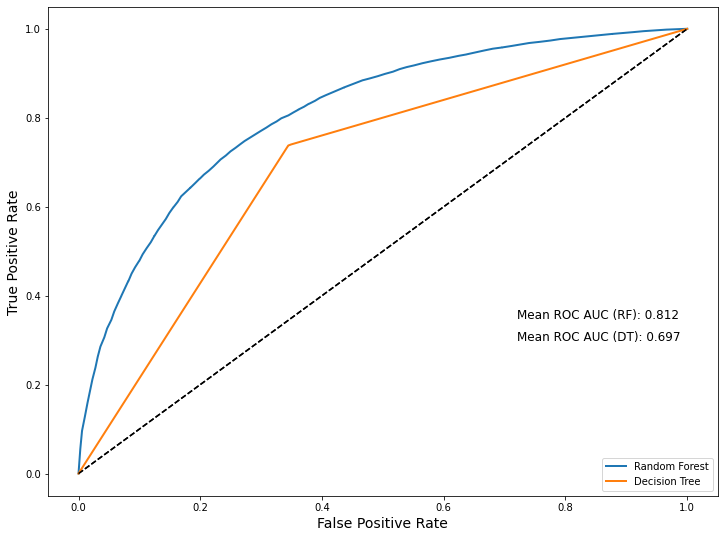

In [87]:
plt.figure(figsize = (12,9))
plot_roc_curve(fpr_RF, tpr_RF, "Random Forest") 
plot_roc_curve(fpr_DT, tpr_DT, "Decision Tree") 
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.text(0.72, 0.35, 'Mean ROC AUC (RF): ' + str(round(np.mean(RF_scores),3)), fontsize=12)
plt.text(0.72, 0.30, 'Mean ROC AUC (DT): ' + str(round(np.mean(DT_scores),3)), fontsize=12)
plt.show()

### Model Tuning

In [88]:
RF_clf = RandomForestClassifier()
grid_values = {'n_estimators' : [500, 800], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2]}
grid_RF_clf = GridSearchCV(RF_clf, param_grid = grid_values, cv=skfolds, n_jobs = -1, scoring = 'roc_auc')
grid_RF_clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [500, 800]},
             scoring='roc_auc')

In [89]:
grid_RF_clf.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}

In [90]:
y_pred = grid_RF_clf.predict(X_test)

In [91]:
accuracy = (y_pred == y_test).mean()
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7560446890111723
Precision: 0.7552061010327271
Recall: 0.7560446890111723


In [92]:
# evaluate classification model
def evaluate_model(y_test, y_pred):
    clsReport = classification_report(y_test, y_pred)
    print("Classification report:", clsReport)

evaluate_model(y_test, y_pred)

Classification report:               precision    recall  f1-score   support

         0.0       0.73      0.70      0.71      5201
         1.0       0.78      0.80      0.79      6793

    accuracy                           0.76     11994
   macro avg       0.75      0.75      0.75     11994
weighted avg       0.76      0.76      0.76     11994



### Feature Importance

In [93]:
feature_importances = grid_RF_clf.best_estimator_.feature_importances_
RF_features = pd.DataFrame(sorted(zip(feature_importances, X_train.columns), reverse=True), columns = ['score', 'feature'])

In [94]:
RF_features

,score,feature
0,0.307508,income
1,0.297234,age
2,0.281991,membership_years
3,0.030021,offer_encoded
4,0.021955,M
5,0.019558,reward
6,0.013251,difficulty
7,0.010264,duration
8,0.009779,social
9,0.006477,mobile


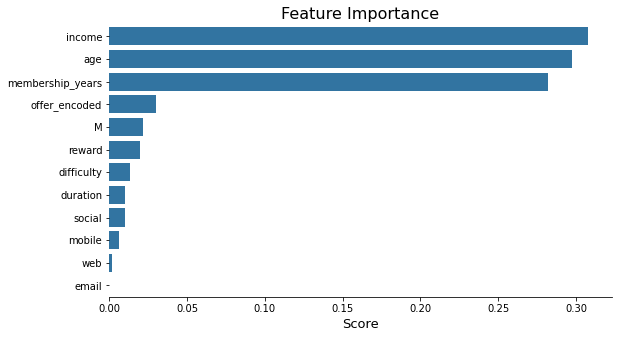

In [95]:
fig, ax = plt.subplots(figsize = [9, 5])
base_color = sns.color_palette()[0]
ax = sns.barplot(x = RF_features['score'], y = RF_features['feature'], color=base_color)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('Score', fontsize=13)
ax.set_title('Feature Importance', fontsize=16)
plt.show()

### Further improvement and modeling
> - Model that predicts how much someone will spend based on demographics and offer type. (age, income, gender, became_member_on)
> - Recommendation engine FunkSVD
> - Customer segmentation using unsupervised machine learning model: K-Means Clustering with PCA

In [97]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_Challenge.ipynb'])

0